SearchResult containing 12 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 01 2018              SPOC     120   231698181      0.0
  1 TESS Sector 68 2023              SPOC      20   231698181      0.0
  2 TESS Sector 68 2023              SPOC     120   231698181      0.0
  3 TESS Sector 01 2018         TESS-SPOC    1800   231698181      0.0
  4 TESS Sector 68 2023         TESS-SPOC     200   231698181      0.0
  5 TESS Sector 01 2018               QLP    1800   231698181      0.0
  6 TESS Sector 68 2023               QLP     200   231698181      0.0
  7 TESS Sector 01 2018             TASOC     120   231698181      0.0
  8 TESS Sector 01 2018 GSFC-ELEANOR-LITE    1800   231698181      0.0
  9 TESS Sector 01 2018             TASOC    1800   231698181      0.0
 10 TESS Sector 01 2018           

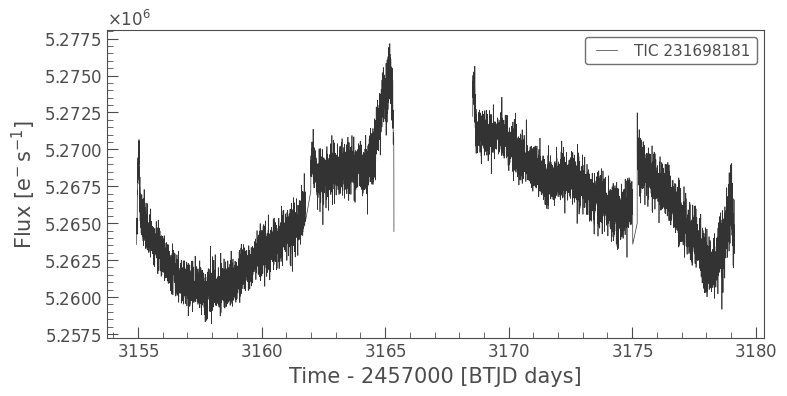

In [38]:
from lightkurve import search_lightcurve
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import matplotlib.pyplot as plt

#this is a test document for tinkering with data processing methods.
#for example usage refer to lightcurve_example_usage.ipynb

#search for lightcurve data instead of using downloaded data
search_results = search_lightcurve('TIC 231698181', mission='TESS')
print(search_results)

lc = search_results[4].download()
lc.plot()
plt.show()

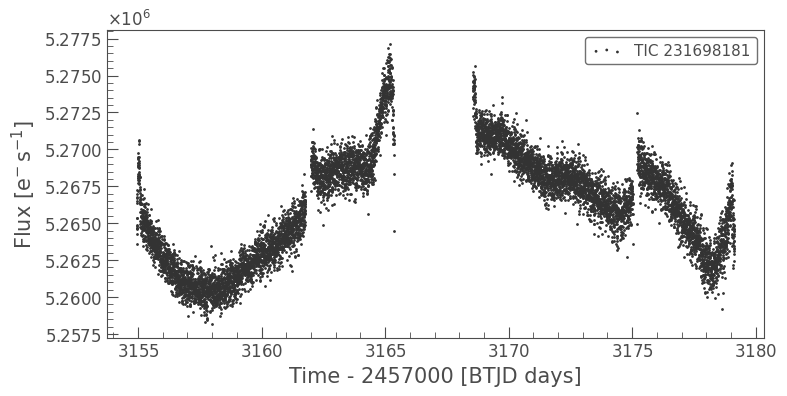

In [39]:
#same initial methodology in example usage
lc = lc.remove_nans().remove_outliers()
lc.scatter()
plt.show()

24


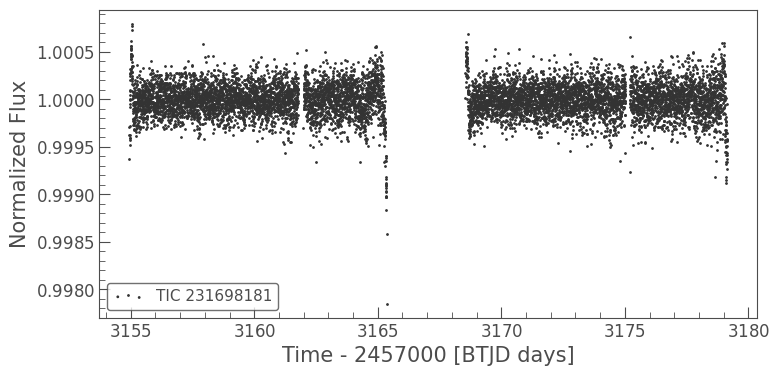

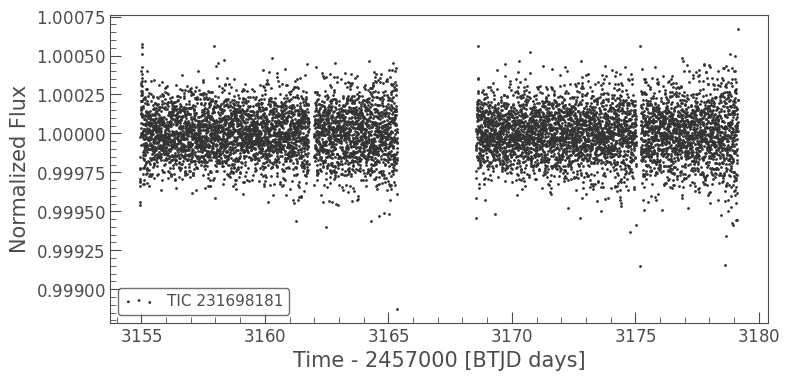

In [40]:
#testing two methods of flattening data: 
#one with window based on observation time, second with default window
#dynamic window seems to have issues with sparse data

def get_number_of_days(lightcurve):
    time = lightcurve.time
    number_of_days = (time.max() - time.min()).value
    return number_of_days

observation_time = int(get_number_of_days(lc))
print(observation_time)
dynamic_window = observation_time*30


dflat_lc = lc.flatten(window_length=dynamic_window)
dflat_lc.scatter()
plt.show()

flat_lc = lc.flatten()
flat_lc.scatter()
plt.show()

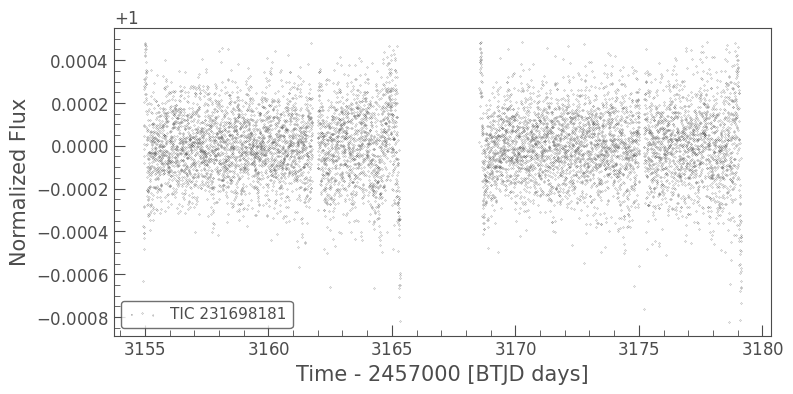

In [41]:
clipped_lc = dflat_lc.remove_outliers(sigma_upper=3, sigma_lower=5)
clipped_lc.scatter(s=0.1)
plt.show()

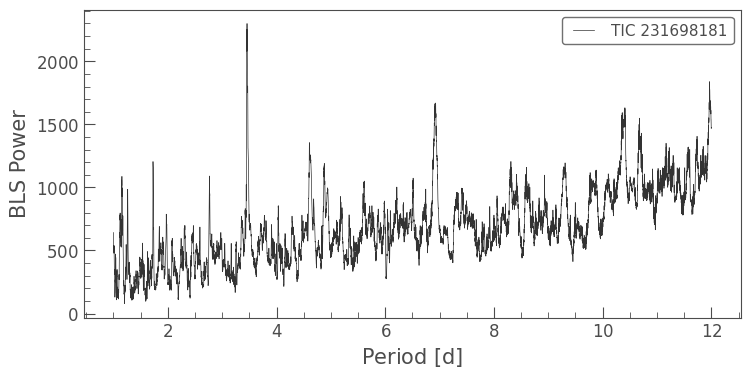

In [42]:
import numpy as np
periodogram = clipped_lc.to_periodogram(method="bls", period=np.arange(1, observation_time/2, 0.001))
periodogram.plot()
plt.show()

In [43]:
#I would like to try creating a mathmatical representation of -
#the likelyhood a planet transit event is captured within this data. 

import numpy as np

# Ensure the frequency array is sorted
sorted_indices = np.argsort(periodogram.frequency)
sorted_frequency = periodogram.frequency[sorted_indices]
sorted_power = periodogram.power[sorted_indices]

# Calculate the area under the curve of the periodogram
area = np.trapezoid(sorted_power, sorted_frequency)

print("Area under the curve:", area)

#This is still under construction. I don't think it gives an effective score yet.
#if the power is too low it will give high scores.
score = periodogram.power.max() / area
print("Score:", score)



#a different method to test: ratio between average power and maximum power.
max_power = periodogram.power.max()
average_power = np.mean(periodogram.power)

ratio = max_power / average_power
print("Ratio:", ratio)

Area under the curve: 406.0903052152157 1 / d
Score: 5.662084361696826 d
Ratio: 3.3557248950989376


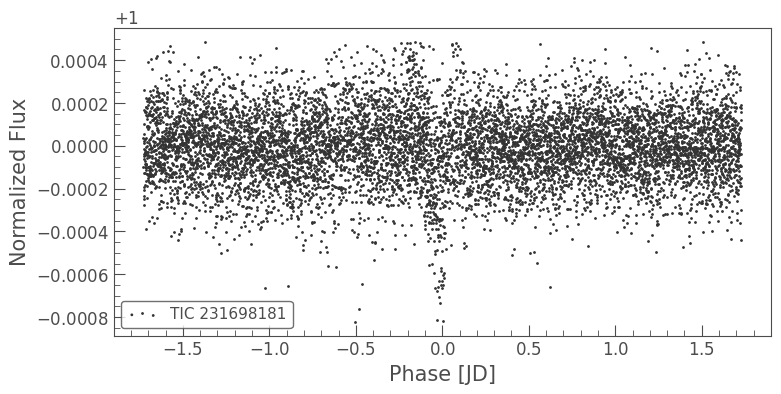

In [44]:
best_fit_period = periodogram.period_at_max_power
folded_lc = clipped_lc.fold(period=best_fit_period)
folded_lc.scatter()
plt.show()

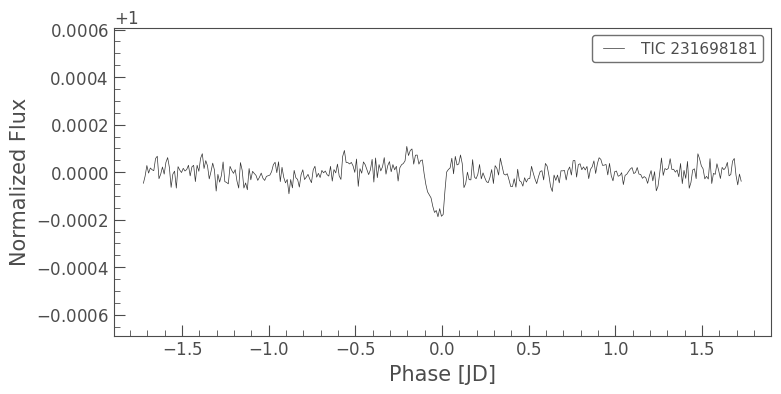

In [45]:
binned_lc = folded_lc.bin(time_bin_size=0.01)
binned_lc.plot()
plt.ylim([min(binned_lc.flux) - 0.0005, max(binned_lc.flux) + 0.0005])
plt.show()